Restarted GenAMM (Python 3.11.4)

In [1]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_swap = df_swap[[
    'block_number', 'amount0', 'transaction_price',
    'Event', 'amount1', 'tick', 'log_index', 'liquidity']]
df_swap_x2y = df_swap[ df_swap.Event=='Swap_X2Y' ]
df_swap_y2x = df_swap[ df_swap.Event=='Swap_Y2X' ]

In [2]:
tot_delta_block = df_swap.block_number.diff().dropna().values
event_type = df_swap.Event.values[1:]
x2y_delta_block = df_swap_x2y.block_number.diff().dropna().values
y2x_delta_block = df_swap_y2x.block_number.diff().dropna().values

{'alpha': 0.3093982404455748, 'l': 0.1138194225863076, 'loc': -1.0001664744897822, 'scale': 1.0000836040765773, 'neg_ll': 1879932.77000701}


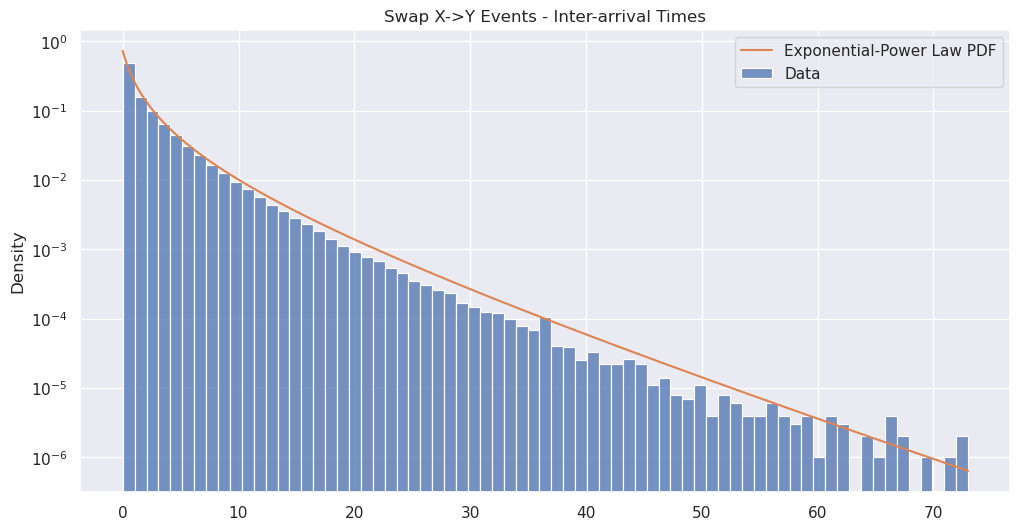

In [7]:

y_temp = df_swap_x2y.block_number.diff().dropna().values

ple_pars = qPowerLaw.PowerLaw_exp_fit(y_temp, n_it=100, seed=2)
print(ple_pars)

y_temp = y_temp[y_temp < 80]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, bins=len(np.unique(y_temp)), ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = qPowerLaw.PowerLaw_exp_pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *list(ple_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Exponential-Power Law PDF')

plt.title("Swap X->Y Events - Inter-arrival Times")
ax.legend()
plt.show()

{'q': 1.3514626958609215, 'alpha': 0.08942535546345563, 'l': 0.25635344785538766, 'loc': -1.0004494465779985, 'scale': 1.0003827924845015, 'neg_ll': 1887935.6659167858}


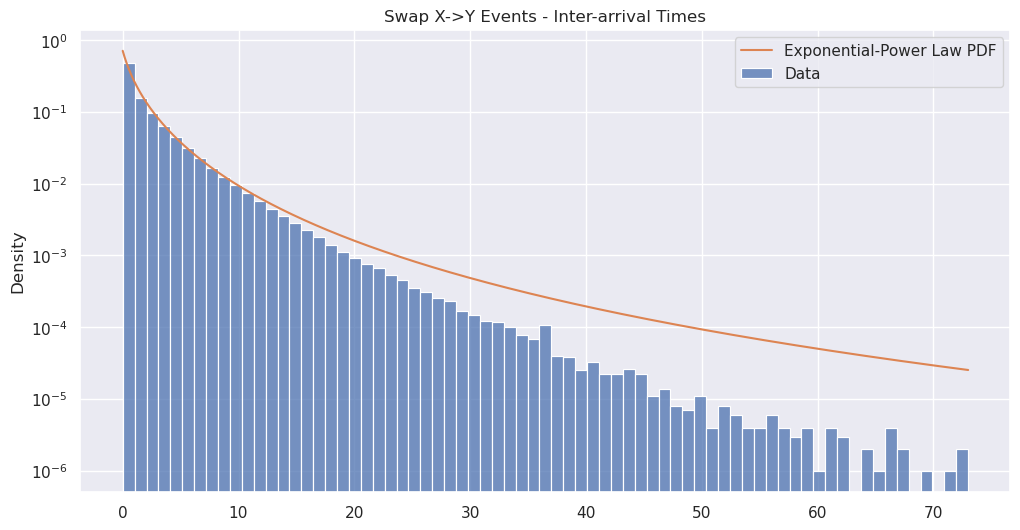

In [3]:

y_temp = df_swap_x2y.block_number.diff().dropna().values

ple_pars = qPowerLaw.fit(y_temp, n_it=100, seed=2, ub=[2.95,2,2,np.min(y_temp)-1e-2,np.inf])
print(ple_pars)

y_temp = y_temp[y_temp < 80]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, bins=len(np.unique(y_temp)), ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = qPowerLaw.pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *list(ple_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Exponential-Power Law PDF')

plt.title("Swap X->Y Events - Inter-arrival Times")
ax.legend()
plt.show()


In [3]:
# Comparison with other distributions
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3, pareto
y_temp = df_swap_x2y.block_number.diff().dropna().values

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))
    
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'expPowerLaw', 'qPowerLaw']):
    try:
        if name not in ['expPowerLaw', 'qPowerLaw']:
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(y_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        elif name == 'expPowerLaw':
            pars = dist.PowerLaw_exp_fit(y_temp, seed=2)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.PowerLaw_exp_pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        elif name == 'qPowerLaw':
            pars = dist.fit(y_temp, seed=2)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (-1.684621769384125e-11, 1.4678182359666263)
Half-Cauchy - Log-Likelihood: -1955078.3768179815

Fatigue Life - Parameters: (2630.3444916583176, -1.2955101446856906e-14, 2.6432932294550255e-07)
Fatigue Life - Log-Likelihood: 3571822.6527420976

Generalized Pareto - Parameters: (0.6761521151495695, -3.020564469043301e-11, 1.164679851567711)
Generalized Pareto - Log-Likelihood: -1922472.0473475896

Kappa 3 - Parameters: (1.6543805744719156, -1.7529265435554179e-10, 1.790179981980053)
Kappa 3 - Log-Likelihood: -1921853.8597226492

Pareto - Parameters: (3.317082666323573, -6.334805543283994, 6.334805543283993)
Pareto - Log-Likelihood: -1891946.1033502414

expPowerLaw - Parameters: [13.484617187769091, 2.4022910717395085, -41.0584313871836, 41.049849363162025]
expPowerLaw - Log-Likelihood: -1917120.1451043154

qPowerLaw - Error: '<' not supported between instances of 'NoneType' and 'float'

The best distribution is: Fatigue Life, with a Log-Likelihood of 3571822.652

In [4]:
# Comparison test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}
'''
y_temp = df_swap_x2y.block_number.diff().dropna().values

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = qPowerLaw
top_pars = list(qPowerLaw.PowerLaw_exp_fit(y_temp).values())[:-1]
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.PowerLaw_exp_pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")
'''

'\ny_temp = df_swap_x2y.block_number.diff().dropna().values\n\nboot_test = Fit_comparison_test(one_side=True, n_boot=10_000)\nrandom_seed = 2\n\ntop_dist = qPowerLaw\ntop_pars = list(qPowerLaw.PowerLaw_exp_fit(y_temp).values())[:-1]\nfor dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],\n                      [\'Half-Cauchy\', \'Generalized Pareto\', \'Kappa 3\', \'FatigueLife\', \'qPowerLaw\']):\n    if name != \'qPowerLaw\':\n        temp_par = dist.fit(y_temp)\n        test_res = boot_test(\n            y_temp, lambda x: top_dist.PowerLaw_exp_pdf(x, *top_pars),\n            lambda x: dist.pdf(x, *temp_par), random_seed)\n    else:\n        temp_par = dist.fit(y_temp)\n        test_res = boot_test(\n            y_temp, lambda x: top_dist.pdf(x, *top_pars),\n            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)\n    print(f"{name} - test result: {test_res}")\n'

In [3]:
# Comparison with other distributions
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3, pareto
y_temp = df_swap_x2y.block_number.diff().dropna().values

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))
    
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'expPowerLaw', 'qPowerLaw']):
    try:
        if name not in ['expPowerLaw', 'qPowerLaw']:
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(y_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        elif name == 'expPowerLaw':
            pars = dist.PowerLaw_exp_fit(y_temp, n_it=100, seed=2)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.PowerLaw_exp_pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        elif name == 'qPowerLaw':
            pars = dist.fit(y_temp, n_it=100, seed=2, ub=[2.95,2,2,np.min(y_temp)-1e-2,np.inf])
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (-1.684621769384125e-11, 1.4678182359666263)
Half-Cauchy - Log-Likelihood: -1955078.3768179815

Fatigue Life - Parameters: (2630.3444916583176, -1.2955101446856906e-14, 2.6432932294550255e-07)
Fatigue Life - Log-Likelihood: 3571822.6527420976

Generalized Pareto - Parameters: (0.6761521151495695, -3.020564469043301e-11, 1.164679851567711)
Generalized Pareto - Log-Likelihood: -1922472.0473475896

Kappa 3 - Parameters: (1.6543805744719156, -1.7529265435554179e-10, 1.790179981980053)
Kappa 3 - Log-Likelihood: -1921853.8597226492

Pareto - Parameters: (3.317082666323573, -6.334805543283994, 6.334805543283993)
Pareto - Log-Likelihood: -1891946.1033502414

expPowerLaw - Parameters: [0.3093982404455748, 0.1138194225863076, -1.0001664744897822, 1.0000836040765773]
expPowerLaw - Log-Likelihood: -1879932.77000701

qPowerLaw - Parameters: [1.3514626958609215, 0.08942535546345563, 0.25635344785538766, -1.0004494465779985, 1.0003827924845015]
qPowerLaw - Log-Likelihood: -1

In [4]:
# Comparison test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}

In [5]:
y_temp = df_swap_x2y.block_number.diff().dropna().values

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = qPowerLaw
top_pars = list(qPowerLaw.PowerLaw_exp_fit(y_temp, n_it=100, seed=2).values())[:-1]
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.PowerLaw_exp_pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(y_temp, n_it=100, seed=2, ub=[2.95,2,2,np.min(y_temp)-1e-2,np.inf])
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")

Half-Cauchy - test result: {'statistic': -289.0843638921954, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -239.84333060614532, 'p_value': 0.0}
Kappa 3 - test result: {'statistic': -144.04613182955165, 'p_value': 0.0}
FatigueLife - test result: {'statistic': 441.1696358713159, 'p_value': 1.0}
qPowerLaw - test result: {'statistic': nan, 'p_value': 0.0}


{'alpha': 0.3093982404455748, 'l': 0.1138194225863076, 'loc': -1.0001664744897822, 'scale': 1.0000836040765773, 'neg_ll': 1879932.77000701}


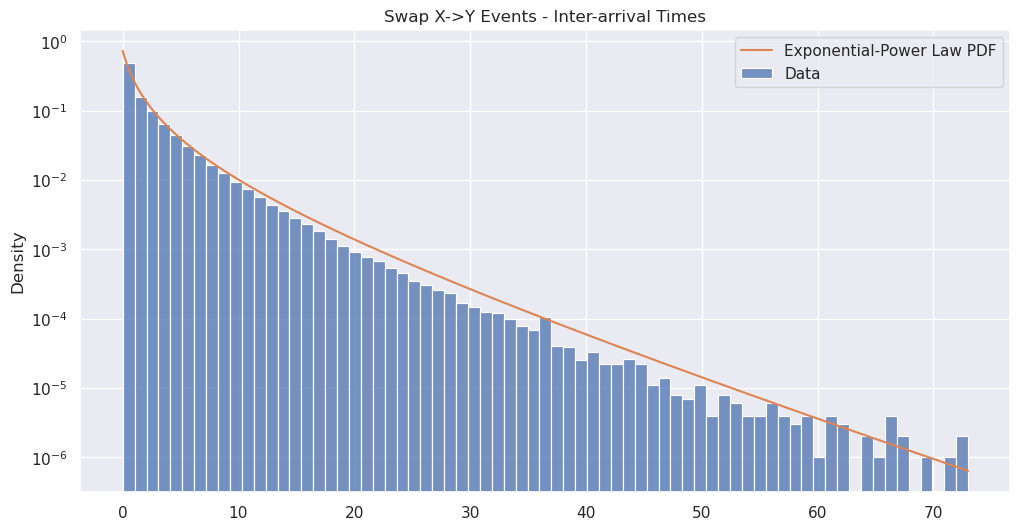

In [6]:

y_temp = df_swap_x2y.block_number.diff().dropna().values

ple_pars = qPowerLaw.PowerLaw_exp_fit(y_temp, n_it=100, seed=2)
print(ple_pars)

y_temp = y_temp[y_temp < 80]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, bins=len(np.unique(y_temp)), ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = qPowerLaw.PowerLaw_exp_pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *list(ple_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Exponential-Power Law PDF')

plt.title("Swap X->Y Events - Inter-arrival Times")
ax.legend()
plt.show()

In [7]:
# Comparison with other distributions
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3, pareto
y_temp = df_swap_y2x.block_number.diff().dropna().values

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))
    
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'expPowerLaw', 'qPowerLaw']):
    try:
        if name not in ['expPowerLaw', 'qPowerLaw']:
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(y_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        elif name == 'expPowerLaw':
            pars = dist.PowerLaw_exp_fit(y_temp, n_it=100, seed=2)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.PowerLaw_exp_pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        elif name == 'qPowerLaw':
            pars = dist.fit(y_temp, n_it=100, seed=2, ub=[2.95,2,2,np.min(y_temp)-1e-2,np.inf])
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (-2.1593837828959295e-14, 1.4343749999999966)
Half-Cauchy - Log-Likelihood: -1945262.0278876082

Fatigue Life - Parameters: (2114.0341118160823, -6.408800492126674e-14, 1.0950733473622687e-06)
Fatigue Life - Log-Likelihood: 3354314.6020690356

Generalized Pareto - Parameters: (1.3529641193156245, -5.37544175025661e-11, 1.0365014540730346)
Generalized Pareto - Log-Likelihood: -1961930.9101798972

Kappa 3 - Parameters: (1.579045414493958, -8.28327622274369e-05, 1.7460707680855254)
Kappa 3 - Log-Likelihood: -1913509.8078679147

Pareto - Parameters: (3.069215376558237, -5.713825838967544, 5.713825838967543)
Pareto - Log-Likelihood: -1883088.9099473148

expPowerLaw - Parameters: [0.14958068850314055, 0.06493559542396145, -0.5824451613612286, 0.5804119636966805]
expPowerLaw - Log-Likelihood: -1864773.891205955

qPowerLaw - Parameters: [1.351462560714752, 0.08942534652102009, 0.2553055043504105, -1.0003284521642097, 1.0002767275232902]
qPowerLaw - Log-Likelihood: -18

In [8]:
y_temp = df_swap_y2x.block_number.diff().dropna().values

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = qPowerLaw
top_pars = list(qPowerLaw.PowerLaw_exp_fit(y_temp, n_it=100, seed=2).values())[:-1]
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.PowerLaw_exp_pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(y_temp, n_it=100, seed=2, ub=[2.95,2,2,np.min(y_temp)-1e-2,np.inf])
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")

Half-Cauchy - test result: {'statistic': -237.0067345695049, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -538.2720012195884, 'p_value': 0.0}
Kappa 3 - test result: {'statistic': -133.10762880284918, 'p_value': 0.0}
FatigueLife - test result: {'statistic': 453.2391674690983, 'p_value': 1.0}
qPowerLaw - test result: {'statistic': nan, 'p_value': 0.0}


{'alpha': 0.14958068850314055, 'l': 0.06493559542396145, 'loc': -0.5824451613612286, 'scale': 0.5804119636966805, 'neg_ll': 1864773.891205955}


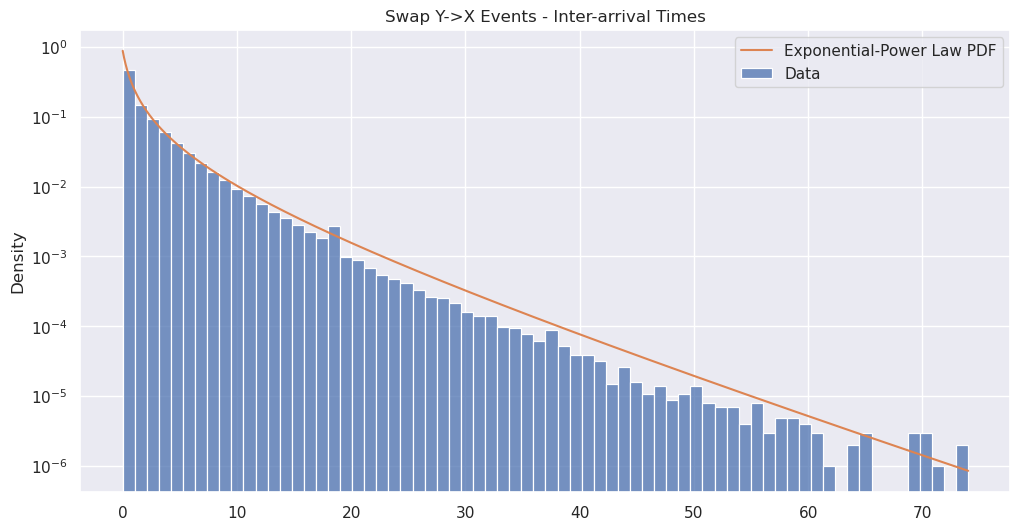

In [10]:

y_temp = df_swap_y2x.block_number.diff().dropna().values

ple_pars = qPowerLaw.PowerLaw_exp_fit(y_temp, n_it=100, seed=2)
print(ple_pars)

y_temp = y_temp[y_temp < 80]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, bins=len(np.unique(y_temp)), ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = qPowerLaw.PowerLaw_exp_pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *list(ple_pars.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Exponential-Power Law PDF')

plt.title("Swap Y->X Events - Inter-arrival Times")
ax.legend()
plt.show()

(2114.0341118160823, -6.408800492126674e-14, 1.0950733473622687e-06)


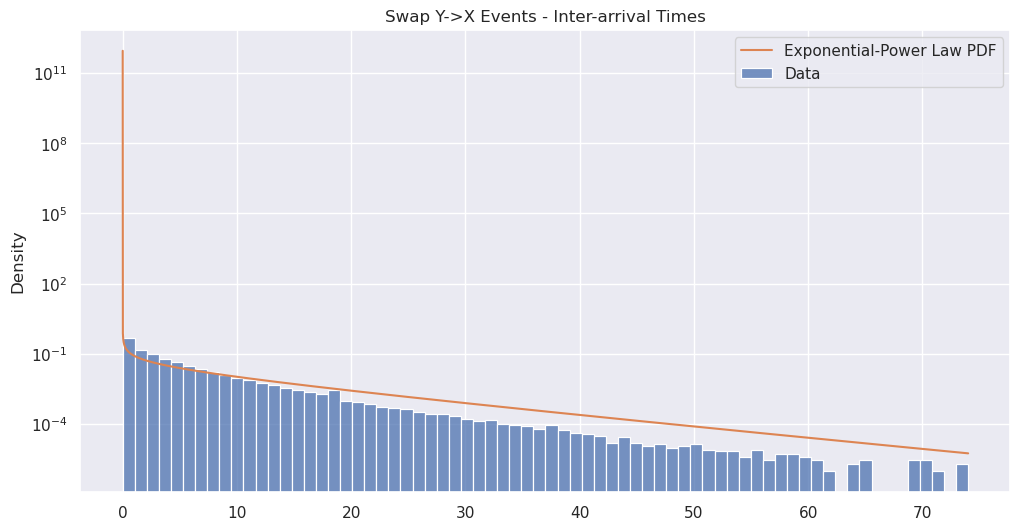

In [11]:

y_temp = df_swap_y2x.block_number.diff().dropna().values

ple_pars = fatiguelife.fit(y_temp)
print(ple_pars)

y_temp = y_temp[y_temp < 80]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, bins=len(np.unique(y_temp)), ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = fatiguelife.pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *ple_pars)
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Exponential-Power Law PDF')

plt.title("Swap Y->X Events - Inter-arrival Times")
ax.legend()
plt.show()

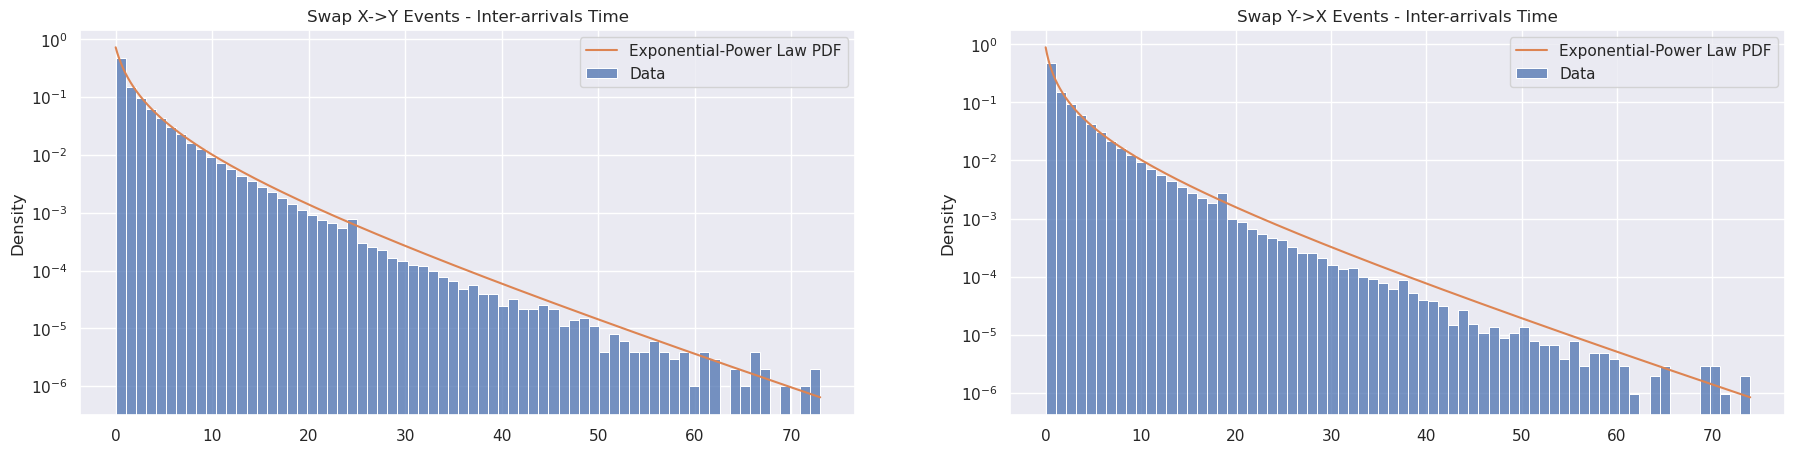

In [13]:

y_temp_x2y = df_swap_x2y.block_number.diff().dropna().values
y_temp_y2x = df_swap_y2x.block_number.diff().dropna().values

ple_pars_x2y = qPowerLaw.PowerLaw_exp_fit(y_temp_x2y, n_it=100, seed=2)
ple_pars_y2x = qPowerLaw.PowerLaw_exp_fit(y_temp_y2x, n_it=100, seed=2)

y_temp_x2y = y_temp_x2y[y_temp_x2y < 80]
y_temp_y2x = y_temp_y2x[y_temp_y2x < 80]

# Plot the data - Joint swaps X->Y and Y->X
fig, ax = plt.subplots(1, 2, figsize=(22, 5))

sns.histplot(y_temp_x2y, bins=len(np.unique(y_temp_x2y)), ax=ax[0], stat='density', label='Data')
ax[0].set_yscale('log')
ax[0].set_title("Swap X->Y Events - Inter-arrivals Time")
pdf_x2y = qPowerLaw.PowerLaw_exp_pdf(np.linspace(np.min(y_temp_x2y), np.max(y_temp_x2y), 10000), *list(ple_pars_x2y.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp_x2y), np.max(y_temp_x2y), 10000),
             y=pdf_x2y,
            ax=ax[0], color=sns.color_palette()[1], label='Exponential-Power Law PDF')
ax[0].legend()

sns.histplot(y_temp_y2x, bins=len(np.unique(y_temp_y2x)), ax=ax[1], stat='density', label='Data')
ax[1].set_yscale('log')
ax[1].set_title("Swap Y->X Events - Inter-arrivals Time")
pdf_y2x = qPowerLaw.PowerLaw_exp_pdf(np.linspace(np.min(y_temp_y2x), np.max(y_temp_y2x), 10000), *list(ple_pars_y2x.values())[:-1])
sns.lineplot(x=np.linspace(np.min(y_temp_y2x), np.max(y_temp_y2x), 10000),
             y=pdf_y2x,
            ax=ax[1], color=sns.color_palette()[1], label='Exponential-Power Law PDF')
ax[1].legend()

plt.show()

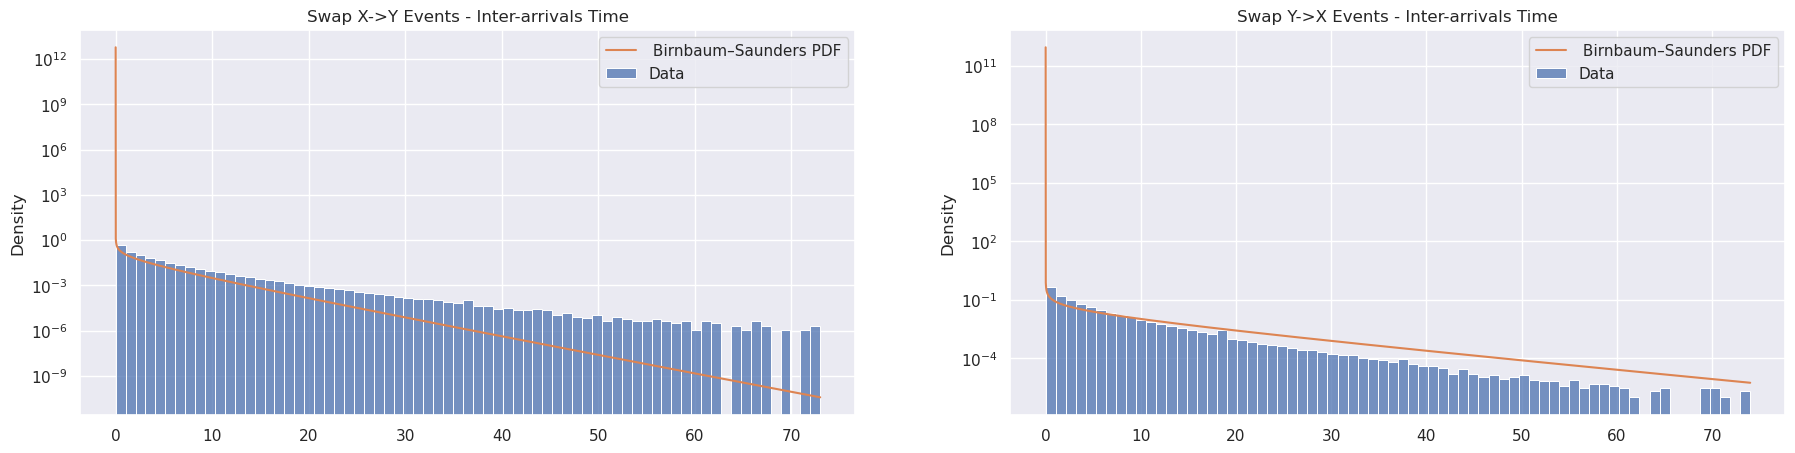

In [6]:
from scipy.stats import fatiguelife

y_temp_x2y = df_swap_x2y.block_number.diff().dropna().values
y_temp_y2x = df_swap_y2x.block_number.diff().dropna().values

ple_pars_x2y = fatiguelife.fit(y_temp_x2y)
ple_pars_y2x = fatiguelife.fit(y_temp_y2x)

y_temp_x2y = y_temp_x2y[y_temp_x2y < 80]
y_temp_y2x = y_temp_y2x[y_temp_y2x < 80]

# Plot the data - Joint swaps X->Y and Y->X
fig, ax = plt.subplots(1, 2, figsize=(22, 5))

sns.histplot(y_temp_x2y, bins=len(np.unique(y_temp_x2y)), ax=ax[0], stat='density', label='Data')
ax[0].set_yscale('log')
ax[0].set_title("Swap X->Y Events - Inter-arrivals Time")
pdf_x2y = fatiguelife.pdf(np.linspace(np.min(y_temp_x2y), np.max(y_temp_x2y), 10000), *ple_pars_x2y)
sns.lineplot(x=np.linspace(np.min(y_temp_x2y), np.max(y_temp_x2y), 10000),
             y=pdf_x2y,
            ax=ax[0], color=sns.color_palette()[1], label=' Birnbaum–Saunders PDF')
ax[0].legend()

sns.histplot(y_temp_y2x, bins=len(np.unique(y_temp_y2x)), ax=ax[1], stat='density', label='Data')
ax[1].set_yscale('log')
ax[1].set_title("Swap Y->X Events - Inter-arrivals Time")
pdf_y2x = fatiguelife.pdf(np.linspace(np.min(y_temp_y2x), np.max(y_temp_y2x), 10000), *ple_pars_y2x)
sns.lineplot(x=np.linspace(np.min(y_temp_y2x), np.max(y_temp_y2x), 10000),
             y=pdf_y2x,
            ax=ax[1], color=sns.color_palette()[1], label=' Birnbaum–Saunders PDF')
ax[1].legend()

plt.show()